# Predição de Perfomance de Estudante

Neste projeto, realizarei uma predição do desempenho de estudantes utilizando o dataset sintético Predict Student Performance do Kaggle. Esse conjunto de dados foi criado para representar fatores-chave do mundo real, como hábitos de estudo, padrões de sono, histórico socioeconômico e frequência às aulas.

Dataset: https://www.kaggle.com/datasets/stealthtechnologies/predict-student-performance-dataset

# Objetivo

O objetivo da predição é oferecer às escolas uma visão detalhada das rotinas e comportamentos que diferenciam os alunos com melhor e pior desempenho. Essa análise permitirá identificar estratégias eficazes para melhorar o rendimento acadêmico de todos os estudantes, promovendo um ambiente educacional mais equilibrado e produtivo.

Para alcançar esse objetivo, empregarei técnicas de aprendizado supervisionado, como Random Forest e Decision Tree , avaliando comparativamente o desempenho de cada modelo na tarefa de predição. Isso permitirá determinar qual abordagem é mais adequada para capturar as relações entre os fatores analisados e o desempenho dos alunos.

### Importando Bibliotecas

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Carregando Dataset

In [34]:
students = pd.read_csv("data.csv")
students.head()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


In [35]:
students.shape

(1388, 5)

### Análise Exploratória

In [37]:
students.columns

Index(['Socioeconomic Score', 'Study Hours', 'Sleep Hours', 'Attendance (%)',
       'Grades'],
      dtype='object')

## Colunas

**Study Hours**

Descrição: Média de horas diárias dedicadas aos estudos.

**Sleep Hours**

Descrição: Média de horas diárias de sono.

**Socioeconomic Score**

Descrição: Uma pontuação normalizada (0-1) que indica o contexto socioeconômico do estudante.

**Attendance (%)**

Descrição: Percentual de aulas frequentadas pelo estudante.

**Grades (TARGET)**

Descrição: Pontuação final de desempenho do estudante, derivada da combinação de horas de estudo, horas de sono, pontuação socioeconômica e frequência.

In [39]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [41]:
students.describe()

,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,0.552274,4.560807,8.047262,58.536023,40.691643
std,0.261272,1.897581,1.370700,11.675287,9.467358
min,0.101280,0.800000,4.800000,40.000000,32.000000
25%,0.322118,3.475000,7.000000,49.000000,34.000000
50%,0.545945,3.900000,8.400000,57.000000,35.000000
75%,0.789610,5.900000,9.100000,66.000000,47.000000
max,0.999820,10.000000,10.000000,100.000000,91.000000


# Verificação de Nulos

In [45]:
students.isnull().sum()

Socioeconomic Score    0
Study Hours            0
Sleep Hours            0
Attendance (%)         0
Grades                 0
dtype: int64

# Distribuição das Variáveis

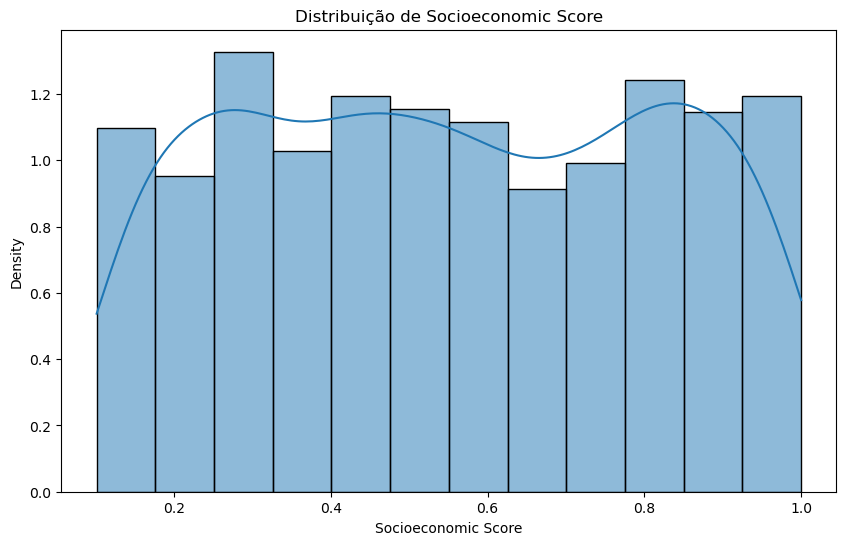

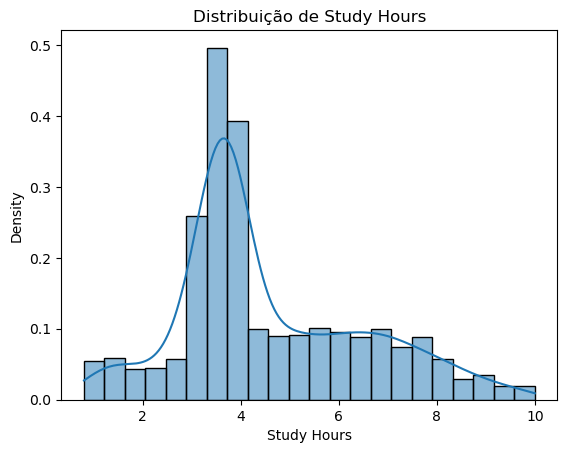

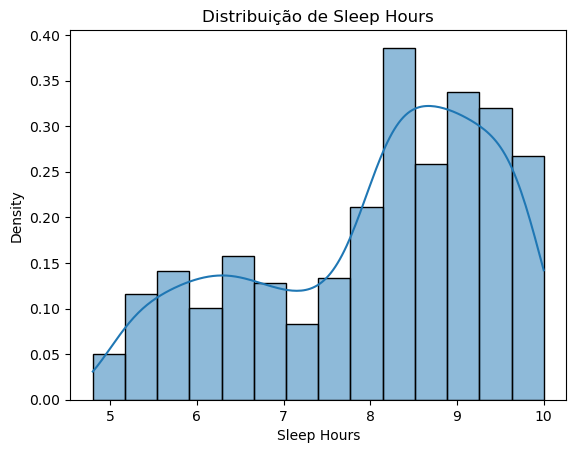

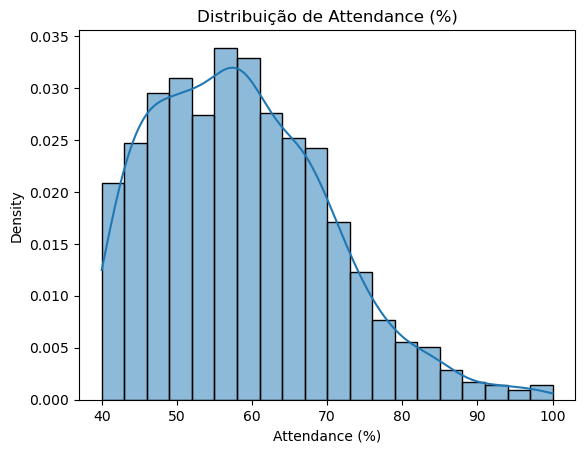

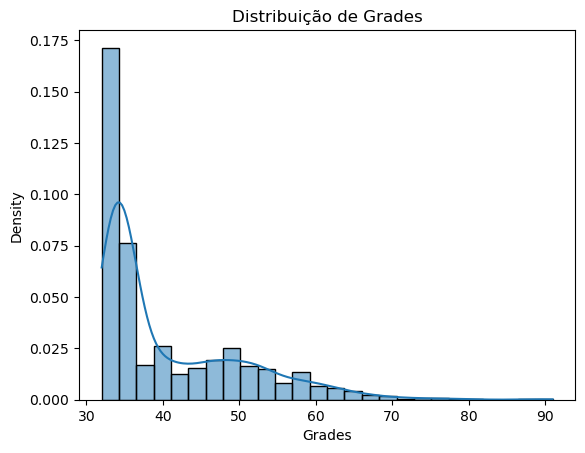

In [47]:
plt.figure(figsize=(10, 6))
for col in students.select_dtypes(include=np.number).columns:
    sns.histplot(students[col], kde=True, stat="density", common_norm=False)
    plt.title(f'Distribuição de {col}')
    plt.show()

# Boxplot

Text(0.5, 1.0, 'Boxplot das Variáveis Numéricas')

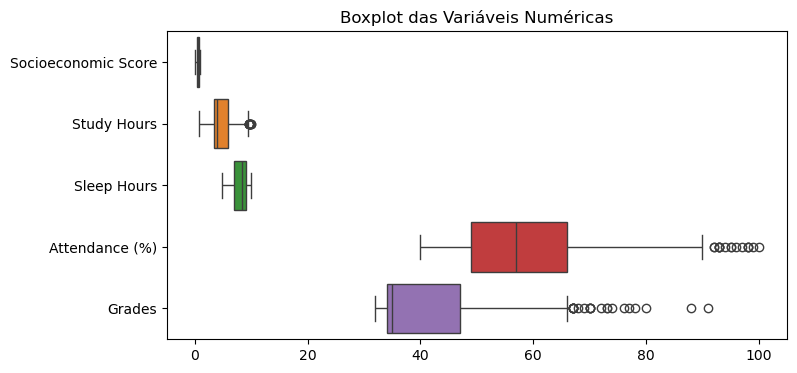

In [50]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=students.select_dtypes(include=np.number), orient="h")
plt.title("Boxplot das Variáveis Numéricas")

## Relatório Análise Univariada

**Socioeconomic Score**: A variável tem uma distribuição concentrada em valores próximos a zero, como já dito antes que os dados já estão normalizados

**Study Hours**: Os estudantes parecem ter uma quantidade razoavelmente consistente de horas dedicadas aos estudos, sem grandes discrepâncias.

**Sleep Hours**: Os estudantes tendem a dormir por um número de horas bastante consistente, sem grandes diferenças individuais.

**Attendance (%):** A frequência de presença varia significativamente entre os estudantes. Alguns alunos frequentam aula quase sempre, enquanto outros têm presença irregular.

**Grades:** As notas dos estudantes variam consideravelmente. A maioria tem notas moderadas, mas há um grupo de alunos com desempenho superior.

Após análise inicial, observei que todas as colunas já estão normalizadas, o que elimina a necessidade de etapas adicionais de feature engineering relacionadas à padronização ou transformação dos dados.

No entanto, identifiquei a presença de outliers , principalmente nas variáveis Attendance (Frequência) e Grades (Notas) . Esses valores extremos são esperados e fazem sentido no contexto do dataset;

Em relação à Attendance , é natural que alguns alunos apresentem taxas de frequência significativamente mais altas do que a média, refletindo um engajamento excepcional com as atividades acadêmicas.
Já em Grades , a existência de notas muito acima da média pode ser explicada pela presença de estudantes com desempenho destacado, o que é consistente com a realidade educacional.
Esses outliers não parecem ser resultado de erros nos dados, mas sim características inerentes à distribuição das variáveis, e podem fornecer insights valiosos para análises futuras.

# Gráfico de Dispersão

Text(0.5, 1.02, 'Relações entre as Variáveis')

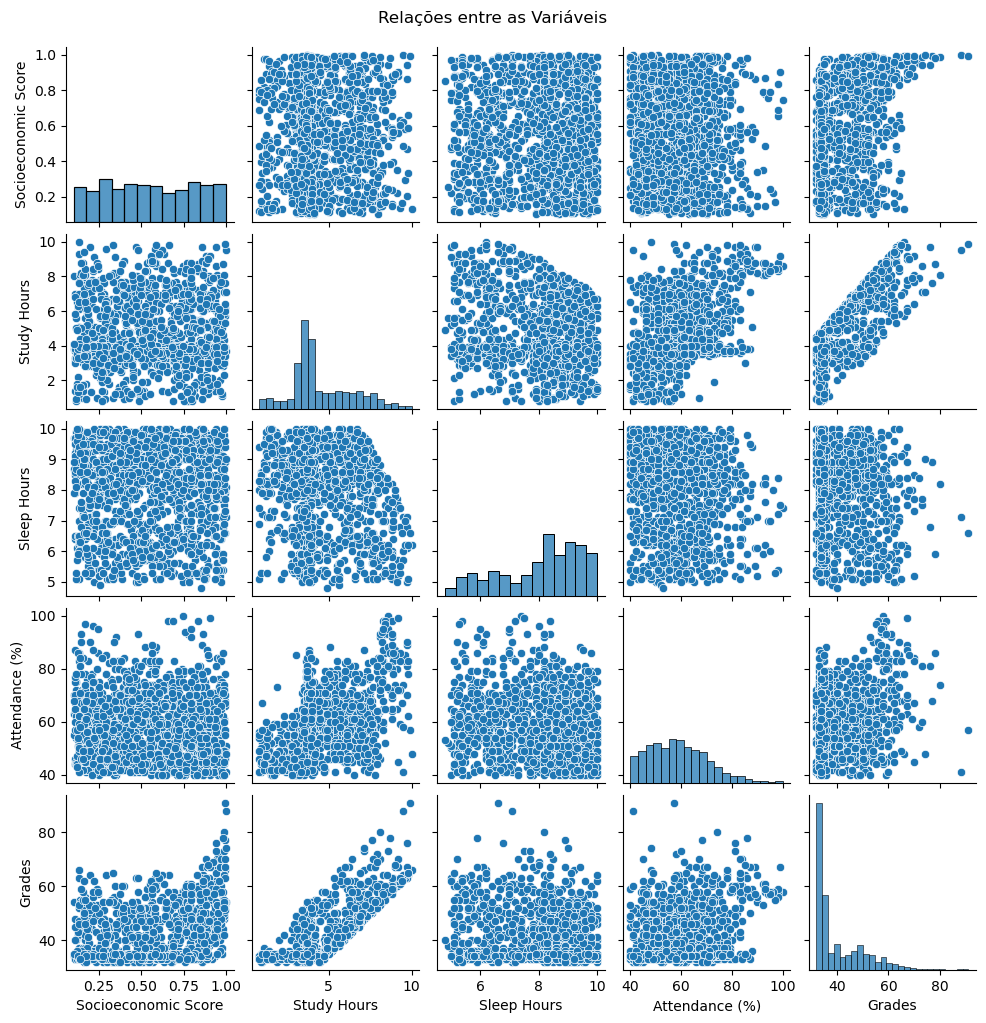

In [55]:
sns.pairplot(students.select_dtypes(include=np.number), height=2.0)
plt.suptitle("Relações entre as Variáveis", y=1.02)

# Matriz de Correlação

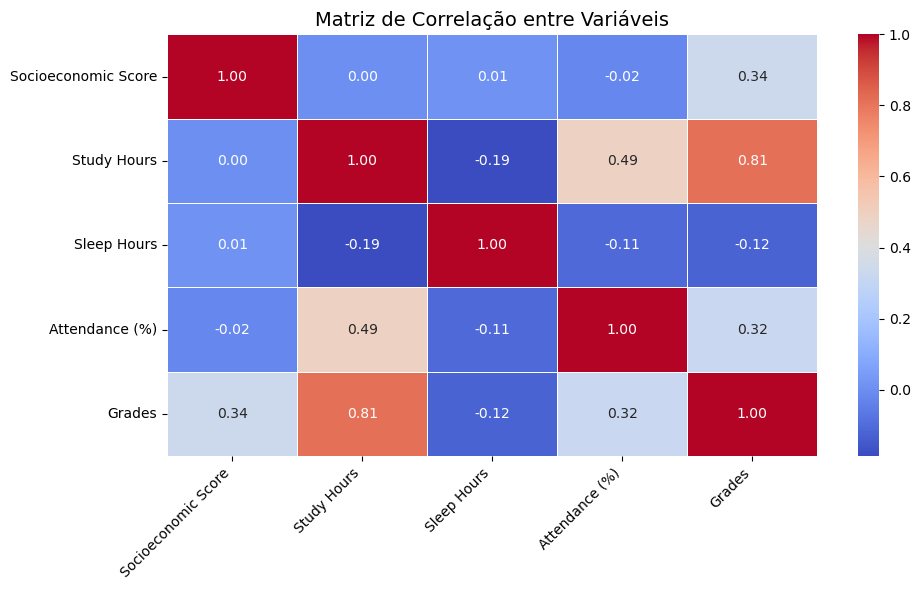

In [57]:
corr_matrix = students.corr()

# Configurar o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            linewidths=0.5,
            annot_kws={"size": 10})

plt.title('Matriz de Correlação entre Variáveis', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Relatório da Análise Bivariada

A matriz de correlação e o gráfico de dispersão forneceram insights valiosos sobre as relações entre as variáveis no contexto do desempenho acadêmico. Destacou-se a importância do tempo dedicado ao estudo (Study Hours (0.81)) como o fator mais relevante para boas notas, seguido pela frequência de presença nas aulas (Attendance % ) e pelo índice socioeconômico (Socioeconomic Score ). Além disso, foi evidenciada a necessidade de equilíbrio entre estudo e descanso, bem como a influência de fatores socioeconômicos no desempenho. Essas informações podem orientar estratégias educacionais eficazes para melhorar o rendimento dos alunos.

### Dados de Treino e Teste

In [60]:
X = students.drop(columns=['Grades'])
y = students['Grades']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré Processamento

In [63]:
numeric_features = X.columns.tolist()  

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())                   
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)  
    ])

Foi utilizado um pipeline para organizar o fluxo de pré-processamento dos dados, garantindo a prevenção de data leakage (vazamento de informações). Dentro do pipeline, foram empregados os seguintes passos:

SimpleImputer : Aplicado para preencher possíveis valores nulos que possam surgir no conjuntos de dados, garantindo que o modelo não seja impactado por lacunas nos dados.

StandardScaler : Utilizado para normalizar as features, transformando-as para que tenham média igual a zero e desvio padrão igual a um. Essa etapa é essencial para algoritmos sensíveis à escala dos dados, como modelos lineares ou baseados em distância.

# Modelagem
A partir daqui decidimos criar dois modelos um de Random Forest e um de DecisionTreeRegressor para que eu possa avaliar qual modelo tem o melhor desempenho

## Random Forest

In [66]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('rf', RandomForestRegressor(random_state=42))
])

# Treinar o modelo
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Socioeconomic Score',
                                                   'Study Hours', 'Sleep Hours',
                                                   'Attendance (%)'])])),
                ('rf', RandomForestRegressor(random_state=42))])

# DecisionTreeRegressor

In [69]:
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('dt', DecisionTreeRegressor(random_state=42))
])

# Treinar o modelo
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Socioeconomic Score',
                                                   'Study Hours', 'Sleep Hours',
                                                   'Attendance (%)'])])),
                ('dt', DecisionTreeRegressor(random_state=42))])

In [71]:
# Fazer previsões
y_pred_rf = rf_pipeline.predict(X_test)

# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Random Forest ===")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

=== Random Forest ===
MAE: 0.8891
MSE: 1.4414
RMSE: 1.2006
R²: 0.9809


In [72]:
# Fazer previsões
y_pred_dt = dt_pipeline.predict(X_test)

# Calcular métricas
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("=== Decision Tree ===")
print(f"MAE: {mae_dt:.4f}")
print(f"MSE: {mse_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")
print(f"R²: {r2_dt:.4f}")

=== Decision Tree ===
MAE: 1.3129
MSE: 3.5935
RMSE: 1.8957
R²: 0.9524


Com base nos resultados obtidos, o modelo Random Forest apresentou um desempenho superior em relação ao Decision Tree na predição do desempenho dos estudantes. Isso pode ser observado pelos menores valores de erro absoluto médio (MAE = 0.8891), erro quadrático médio (MSE = 1.4414) e raiz do erro quadrático médio (RMSE = 1.2006), além de um coeficiente de determinação (R²) de 0.9809, indicando um excelente ajuste aos dados.

Já o modelo Decision Tree obteve métricas de erro significativamente mais altas (MAE = 1.3129, MSE = 3.5935, RMSE = 1.8957) e um R² inferior (0.9524), sugerindo um ajuste menos preciso.

Dessa forma, concluímos que o Random Forest é a melhor escolha para este problema, pois demonstra maior capacidade preditiva e generalização, reduzindo os erros e fornecendo previsões mais confiáveis sobre o desempenho dos estudantes.

# Validação cruzada com R²

Devido ao R² elevado, optei por realizar uma validação cruzada para garantir a confiabilidade do modelo. Um R² muito alto pode, em alguns casos, indicar que o modelo está se ajustando excessivamente aos dados de treino, capturando não apenas padrões reais, mas também ruídos e variações irrelevantes, o que pode levar ao overfitting.

In [75]:
cv_scores = cross_val_score(
    rf_pipeline,  
    X_train,      
    y_train,      
    cv=5,         
    scoring='r2', 
    n_jobs=-1     
)

print("=== Validação Cruzada ===")
print(f"R² médio: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

=== Validação Cruzada ===
R² médio: 0.9766
Desvio padrão: 0.0029


O modelo Random Forest apresentou um R² de 0.9809, indicando que ele explica 98.09% da variabilidade dos dados, o que sugere um excelente ajuste. Para confirmar sua generalização, foi aplicada validação cruzada, resultando em um R² médio de 0.9766, com um desvio padrão de 0.0029.

A pequena diferença entre os valores indica que o modelo não está sofrendo overfitting, pois o desempenho se mantém estável mesmo em diferentes subconjuntos dos dados. Além disso, as métricas de erro (MAE e RMSE) são baixas, reforçando a confiabilidade do modelo. Assim, ele pode ser considerado preciso e generalizável para novos dados.

# Gráfico de Dispersão para demonstrar visualmente o modelo RandomForest

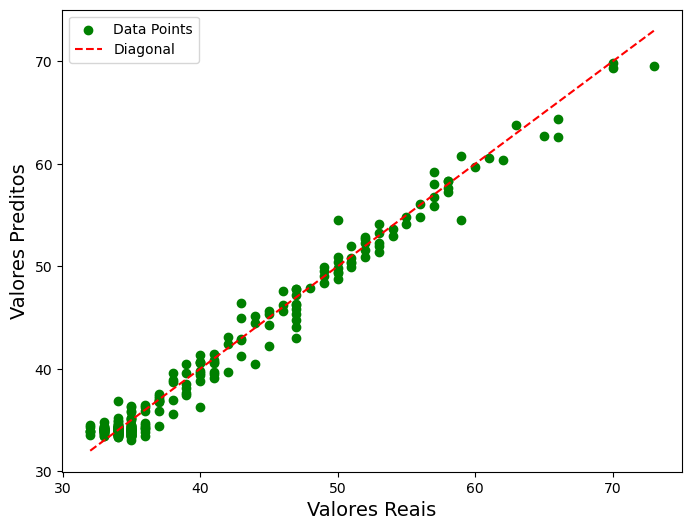

In [78]:
plt.figure(figsize=(8,6))

plt.scatter(y_test, y_pred_rf, c='green', label='Data Points')

plt.xlabel('Valores Reais', fontsize=14)
plt.ylabel('Valores Preditos', fontsize=14)

min_val = min(min(y_test), min(y_pred_rf))
max_val = max(max(y_test), max(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')

plt.legend()

plt.show()

### Conclusão

Neste projeto, empregamos técnicas de machine learning para prever o desempenho dos estudantes com base em um conjunto de dados sintético que simula variáveis reais, como hábitos de estudo e contexto socioeconômico. Ao comparar diferentes abordagens, constatamos que o modelo Random Forest apresentou resultados superiores à árvore de decisão, evidenciando maior precisão e consistência nas previsões.

O Random Forest não só gerou menores índices de erro, mas também demonstrou alta capacidade explicativa dos dados, o que se refletiu em valores de R² próximos de 1. A estabilidade dos resultados, verificada por meio da validação cruzada, reforça a confiança na capacidade do modelo de generalizar bem para novos cenários, minimizando o risco de overfitting.

Com base nos resultados obtidos, concluímos que o Random Forest se destacou como a estratégia mais eficaz para a predição de desempenho estudantil neste dataset. No entanto, devido ao número limitado de variáveis disponíveis, acredita-se que a inclusão de variáveis adicionais e significativas poderia enriquecer ainda mais a base de dados. A ausência dessas variáveis pode estar atenuando as diferenças de desempenho entre os modelos, tornando-os mais similares em termos de resultados.